In [3]:
import torch
from torch import nn
import d2l

def corr2d(X, K):
    """计算二维互相关运算"""
    h, w = K.shape # K 为卷积核
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i+h, j:j+w] * K).sum()
    return Y

In [4]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

In [5]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, X):
        return corr2d(x, self.weight) + self.bias

In [6]:
# 通过找到像素变化的位置，来检测图像中不同颜色的边缘
X = torch.ones((6,8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [7]:
K = torch.tensor([[1.0, -1.0]])

In [8]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [9]:
# 构造一个二维卷积层，它具有1个输出通道和形状为(1,2)的卷积核
conv2d = nn.Conv2d(1, 1, kernel_size=(1,2), bias=False)

# 这个二维卷积层使用四维输入和输出格式（批量大小、通道、高度、宽度），
# 其中批量大小和通道数都为1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2 #学习率

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # 迭代卷积核
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) %2 == 0:
        print(f"epoch {i+1}, loss {l.sum():.3f}")

epoch 2, loss 2.880
epoch 4, loss 0.652
epoch 6, loss 0.178
epoch 8, loss 0.058
epoch 10, loss 0.021


In [10]:
# 本例中，我们创建一个 3*3 的二维卷积层，并在所有侧边填充1个像素

import torch
from torch import nn

# 为了方便起见，我们定义了一个计算卷积层的函数。
# 此函数初始化卷积层权重，并对输入和输出提高和缩减相应的维数
def comp_conv2d(conv2d, X):
    # 这里的（1，1）表示批量大小和通道数都是1
    # 元组加法是扩张元组
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # 省略前两个维度：批量大小和通道
    return Y.reshape(Y.shape[2:])


# 创建一个二维卷积层，输入通道数为 1，输出通道数为 1，卷积核大小为 3x3，填充大小为 1。填充大小为 1 表示在输入的每一边都添加 1 行或 1 列，总共添加 2 行或 2 列。
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [11]:
# 当卷积核的高度和宽度不同时，我们可以填充不同的高度和宽度，使输出和输入具有相同的高度和宽度。
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [12]:
# 有时候为了高效计算或是缩减采样次数，卷积窗口可以跳过中间位置，每次滑动多个元素。我们将每次滑动元素的数量称为步幅（stride）。
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [13]:
# 多通道简单而言就是对每个通道执行互相关操作，然后将结果相加
import torch
import d2l

def corr2d_multi_in(X, K):
    # 先遍历 "X" 和 "K" 的第0个维度（通道维度），再把它们加在一起
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

In [14]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
[[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

In [15]:
# 计算多通道的输出的互相关函数
def corr2d_multi_in_out(X, K):
    # 迭代 "K" 的第0个维度，每次都对输入 "X" 执行互相关运算。
    # 最后将多有结果都叠加在一起
    return torch.stack([corr2d_multi_in(X, k) for k in K], dim=0)

In [16]:
K = torch.stack((K, K+1, K+2), dim=0)
K.shape

torch.Size([3, 2, 2, 2])

In [17]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

In [18]:
def corr2d_multi_in_out_11(X, K):
    ci, h, w = X.shape
    co = K.shape[0]
    X = X.reshape((ci, h*w))
    K = K.reshape((co, ci))
    # 全连接层中的矩阵乘法
    Y = torch.matmul(K, X)
    return Y.reshape((co, h, w))

In [19]:
X = torch.normal(0,1, (3,3,3))
K = torch. normal(0,1, (2,3,1,1))

In [20]:
Y1 = corr2d_multi_in_out_11(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

In [21]:
import torch
from torch import nn
import d2l

In [22]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0]-p_h+1, X.shape[1]-p_w+1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i+p_h, j: j+p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i+p_h, j: j+p_w].mean()
    return Y

In [23]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [24]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

In [25]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [26]:
# 注意这里 kernel_size == stride
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

In [33]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [34]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [39]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [40]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

In [2]:
# LeNet 代码
import torch
from torch import nn
import d2l

net = nn.Sequential(
    # kernel_size=5, padding=2 正好保证模型大小不降
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

In [3]:
X = torch.rand(size=(1,1,28,28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, "output shape: \t", X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [4]:
# 使用 LeNet 在 Fashion-MNIST 数据集上训练
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

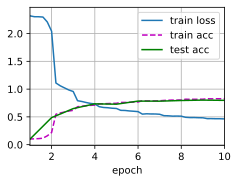

loss 0.464, train acc 0.827, test acc 0.798
46090.1 examples/sec on mps:0


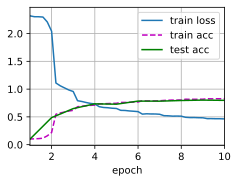

In [5]:
lr, num_epochs = 0.9, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [6]:
import torch
from torch import nn
import d2l

# 接下来使用ReLU激活函数和MaxPool层，来比较差异
net = nn.Sequential(
    # kernel_size=5, padding=2 正好保证模型大小不降
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

In [7]:
# 使用 LeNet 在 Fashion-MNIST 数据集上训练
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

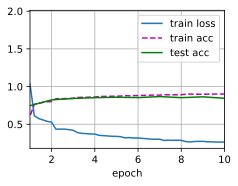

loss 0.265, train acc 0.901, test acc 0.845
54698.9 examples/sec on mps:0


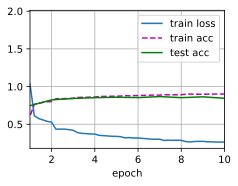

In [8]:
lr, num_epochs = 0.9, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())